Not done yet & to try:

- add constant terms to QAOA
- have a 2nd check at T operation

In [337]:
#BASE
import networkx as nx
from collections import Counter, defaultdict, namedtuple
from itertools import product
import pandas as pd
from scipy.stats import norm
from tqdm import tqdm
import numpy as np

#ML
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as CK
from sklearn.preprocessing import StandardScaler
from sklearn.utils.optimize import _check_optimize_result
from scipy.optimize import minimize

#QUANTUM
from qiskit import Aer, QuantumCircuit, execute

#VIZ
from matplotlib import pyplot as plt

#Set global parameters
s_eigenvalues = [0,1]
penalty = 2
shots = 1000

#Set graph instance & its complement
E = [(0,1), (1,2), (0,2), (2,3), (2,4)]; N = 5
G = nx.Graph()
G.add_nodes_from(range(N))
G.add_edges_from(E)
G_comp = nx.complement(G)

In [357]:
#Functions

def draw_graph(G):
    
    G_comp = nx.complement(G)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (8,4))
    axes[0].set_title("GRAPH")
    axes[1].set_title("COMPLEMETARY GRAPH")
    pos = nx.circular_layout(G)
    nx.draw_networkx(G,ax=axes[0],pos=pos)
    pos = nx.circular_layout(G_comp)
    nx.draw_networkx(G_comp,ax=axes[1],node_color="r",pos=pos)

def s2z(configuration):
    
    return [1-2*s for s in configuration]

def z2s(s):
    
    return [(1-z)/2 for z in configuration]

def str2list(s):
    
    l = []
    skip=False
    for x in s:
        if skip==True:
            skip=False
            continue
        if x == "-":
            l.append(-1)
            skip=True
        if x != "-":
            l.append(int(x))
    return l

def evaluate_cost(configuration, penalty=penalty, basis=None):
    
    '''
    configuration: eigenvalues
    '''
    
    cost=0
    if basis=="S":
        cost = -sum(configuration)
        for edge in G_comp.edges:
            cost += penalty*(configuration[edge[0]]*configuration[edge[1]])            
    elif basis=="Z":          
        cost = -(len(configuration) - sum(configuration))/2 
        for edge in G_comp.edges:
            cost += penalty/4*(1-configuration[edge[0]])*(1-configuration[edge[1]])
    else:
        raise ValueError('Basis should be specified: it must one of ["S","Z"]')
    return cost

def classical_solution(basis=None, show_top=None):  
    
    '''
    Runs through all 2^n possible configurations and estimates how many max cliques there are and plots one
    '''
    
    results = {}
    
    if basis=="S":
        eigenvalues = s_eigenvalues #[0, 1] i.e. fictitious eigenvalues for |0> ad |1> respectively
    elif basis=="Z": 
        eigenvalues = s2z(s_eigenvalues) #[1,-1] i.e. fictitious eigenvalues for |0> ad |1> respectively
    else:
        raise ValueError('Basis should be specified: it must one of ["S","Z"]')
        
    configurations = list(product(eigenvalues, repeat=len(G)))
    for configuration in tqdm(configurations):
        results[configuration] = evaluate_cost(configuration, basis=basis)
    
    print('All possible solutions: \n')
    sol = pd.DataFrame(np.unique(list(results.values()), return_counts = True)).T
    sol.columns=["energy","occurrencies"]
    sol["frequency"]=round(sol["occurrencies"]/sol["occurrencies"].sum()*100,0)
    if show_top is not None:
        print(sol.head(show_top))
    else:
        print(sol)
    d = dict((k, v) for k, v in results.items() if v == np.min(list(results.values())))
    print('\nThere are {} MAXCLIQUE(S): '.format(len(d)), d)
    
    fig = plt.subplot(1, 2, 1)
    val, counts = np.unique(list(results.values()), return_counts = True)
    plt.bar(val, counts)
    plt.xlabel('Energy')
    plt.ylabel('Counts')
    plt.title('Statistics of solutions')

    fig = plt.subplot(1, 2, 2)
    plt.title('MaxClique')
    colors = list(d.keys())[0]
    pos = nx.circular_layout(G)
    nx.draw_networkx(G, node_color=colors, node_size=200, alpha=1, pos=pos)
    
def quantum_algorithm(gamma, beta, penalty):
    
    qc = QuantumCircuit(N,N)
    qc.h(range(N))

    for edge in G_comp.edges: 
        qc.rzz(gamma*penalty/2, edge[0], edge[1])
        qc.rz(-gamma*penalty/2, edge[0]) 
        qc.rz(-gamma*penalty/2, edge[1]) 
        
    for i in G.nodes:
        qc.rz(gamma, i) 
        
    qc.rx(2*beta, range(N)) 
    
    meas = QuantumCircuit(N,N)
    meas.barrier(range(N))
    meas.measure(range(N), range(N))

    return qc + meas
    
def QAOA(gamma, beta, penalty=penalty, shots=shots, basis="S"):
    
    '''
    Applies QAOA
    '''

    backend = Aer.get_backend("qasm_simulator")
    qc = quantum_algorithm(gamma, beta, penalty)
    simulate = execute(qc, backend=backend, shots=shots)
    results = simulate.result()
    extimated_f1 = 0
    counts = results.get_counts()
    pretty_counts = {k[::-1]:v for k,v in counts.items()} 
    if basis=="S":
        pass
    elif basis=="Z":
        pretty_counts = {"".join([str(x) for x in s2z([int(x) for x in k])]):v for k,v in pretty_counts.items()}
    else:
        raise ValueError('Basis should be specified: it must one of ["S","Z"]')

    for configuration in pretty_counts:
        prob_of_configuration = pretty_counts[configuration]/shots
        extimated_f1 += prob_of_configuration*evaluate_cost(str2list(configuration), basis=basis)
    
    return extimated_f1, pretty_counts

def grid_search(num_params, penalty=penalty, shots=shots, show_plot=True):

    QAOA_results = []
    Point = namedtuple("Point", "gamma beta f1")
    lin = np.linspace(0, np.pi, num_params)
    params = np.array(list((product(lin, repeat = 2))))
    
    X = np.unique(params[:,0])
    Y = np.unique(params[:,1])
    X, Y = np.meshgrid(X, Y)
    Q = np.zeros((len(X),len(X)))
    
    for i,j in tqdm(list(product(range(len(X)),repeat=2))):
        Q[i,j], _ = QAOA(X[i,j],Y[i,j], penalty=penalty, shots=shots, basis="S")
    
    if show_plot:

        plt.imshow(Q, extent = [0, np.pi, np.pi, 0])
        plt.title('Grid Search: [{} x {}]'.format(len(X), len(X)))
        plt.xticks(fontsize = 15)
        plt.yticks(fontsize = 15)

        cb = plt.colorbar()
        plt.xlabel(r'$\gamma$', fontsize=20)
        plt.ylabel(r'$\beta$', fontsize =20)
        cb.ax.tick_params(labelsize=15)
        
        points = [Point(*x) for x in np.dstack((X,Y,Q)).reshape(-1,3)]
        
        return points
    
def plot_distribution(freq_dict):

    sorted_freq_dict = dict(sorted(freq_dict.items(), key=lambda item: item[1], reverse=True))
    color_dict = {key: 'g' for key in sorted_freq_dict}
    plt.figure(figsize=(12,6))
    plt.xlabel("configuration")
    plt.ylabel("counts")
    plt.xticks(rotation='vertical')
    plt.bar(sorted_freq_dict.keys(), sorted_freq_dict.values(), width=0.5, color = color_dict.values())
    
#def plot_f1_landscape(params, f1):
#    
#    fig = plt.figure()

#    # Make data.
#    X = np.unique(params[:,0])
#    Y = np.unique(params[:,1])
#    X, Y = np.meshgrid(X, Y)
#    Z = np.reshape(f1, (len(X), len(Y)))

    # Plot the surface.
#    plt.imshow(Z, extent = [0, np.pi, np.pi, 0])
#    plt.title('Grid Search: [{} x {}]'.format(len(X), len(X)))
#    plt.xticks(fontsize = 15)
#    plt.yticks(fontsize = 15)
    
#    cb = plt.colorbar()
#    plt.xlabel(r'$\gamma$', fontsize=20)
#    plt.ylabel(r'$\beta$', fontsize =20)
#    cb.ax.tick_params(labelsize=15)
    
def spectrum_vs_penalty(penalty_min=-2, penalty_max=3, penalty_step=0.5, show_plot=True, basis="S"):
    
    configuration_energies = defaultdict(list)
    penalties=np.arange(penalty_min, penalty_max, penalty_step)
    
    if basis == "S":
        eigenvalues = s_eigenvalues
    elif basis=="Z":
        eigenvalues = s2z(s_eigenvalues)

    for configuration in product(eigenvalues, repeat = len(G)):
        for penalty in penalties:
            configuration_energies[str(configuration)].append(evaluate_cost(str2list(configuration), penalty, basis=basis))

    degeneracies_df = pd.DataFrame(sorted(Counter([v[-1] for k,v in configuration_energies.items()]).items(), key=lambda item: item[0], reverse=False))
    degeneracies_df.columns=["energy","eigenstates"]

    if show_plot:

        for k, v in configuration_energies.items():
            plt.plot(penalties, v, label = k, marker="o")
            plt.xlabel("penalty")
            plt.ylabel("cost")
            #plt.legend()
        plt.show()

    return degeneracies_df, configuration_energies

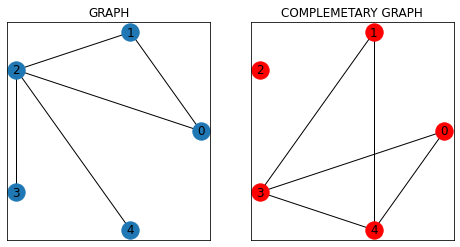

In [18]:
draw_graph(G)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<?, ?it/s]


All possible solutions: 

   energy  occurrencies  frequency
0    -3.0           1.0        3.0
1    -2.0           5.0       16.0
2    -1.0          10.0       31.0
3     0.0           8.0       25.0
4     1.0           2.0        6.0
5     2.0           2.0        6.0
6     3.0           2.0        6.0
7     5.0           1.0        3.0
8     6.0           1.0        3.0

There are 1 MAXCLIQUE(S):  {(-1, -1, -1, 1, 1): -3.0}


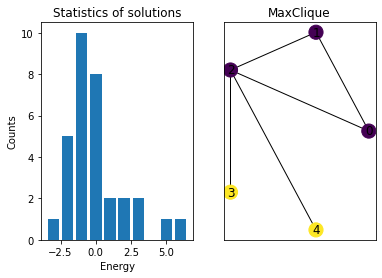

In [19]:
classical_solution(basis="Z")

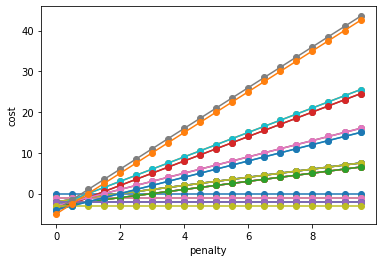

The degeneracies at penalty_max are:


,energy,eigenstates
0,-3.0,1
1,-2.0,5
2,-1.0,5
3,0.0,1
4,6.5,5
5,7.5,5
6,15.0,2
7,16.0,2
8,24.5,2
9,25.5,2


In [3]:
degeneracies_df, configuration_energies = spectrum_vs_penalty(penalty_min=0, penalty_max=10, penalty_step=0.5, basis="Z")
print("The degeneracies at penalty_max are:")
degeneracies_df

In [4]:
#example of use for random parameters...
gamma = 0.2
beta = 0.7
extimated_f1, counts = QAOA(gamma,beta) 

### Gaussian Process to approximate the f1 landscape of a graph

Generates $N_{train}$ points selected randomly on a grid $[gamma-extremes] \times [beta-extremes]$, trains a sklearn Gaussin Process Regressor with a kernel defined by kernel and tests it on $N_{test}^2$ samples uniformly picked on a grid $[0, max(gamma, betas)] \times [0, max(gamma, betas)] $. Result is compared to grid search

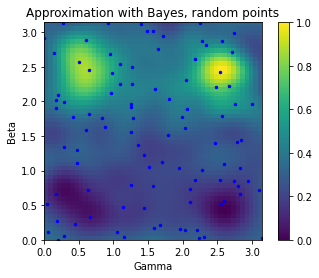

In [335]:
N_train = 100
N_test = 50
gamma_extremes = [0, np.pi]
beta_extremes = [0, np.pi]
X_train = []; y_train = []

for i in range(N_train):
    X = [np.random.uniform(*gamma_extremes), np.random.uniform(*beta_extremes)]
    X_train.append(X)
    Y, _ = QAOA(*X) #in questi casi la base è inifluente: mi serve solo se sono interessato al secondo argomanto
    y_train.append(Y)

kernel = CK(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=0, normalize_y = True)
gp.fit(X_train, y_train)

X_lin = np.linspace(0, np.max([gamma_extremes, beta_extremes]), N_test)
X_test_grid = list(product(X_lin, X_lin))

predicted_means = gp.predict(X_test_grid) 
res = np.reshape(predicted_means, (N_test, N_test)).T #to check the .T: i think it is correct though
X_train = np.array(X_train)
plt.title('Approximation with Bayes, random points')
plt.imshow(res, extent = gamma_extremes + beta_extremes)
plt.scatter(X_train[:,0], X_train[:,1], s=6, c='b')
plt.xlabel('Gamma')
plt.ylabel('Beta')
plt.colorbar()

100%|████████████████████████████████████████████████████████████████████████████████| 900/900 [00:13<00:00, 67.30it/s]


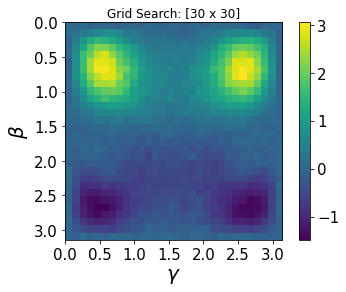

In [339]:
#To confront with
points = grid_search(30)

### Let's see how the QAOA performs on the "optimal" parameters found the by the grid search in the previous cell. Two criteria must be taken into account:

- time
- quality of solution (we could use as a FEM, the approximation ration)

Optimal parameters, according to the grid search, are: {optimal_params}


,configuration,energy,occurrencies,frequency
0,-1-1-111,-3.0,1068,11.0
1,11-1-11,-2.0,985,10.0
2,11-11-1,-2.0,983,10.0
3,-11-111,-2.0,782,8.0
4,1-1-111,-2.0,762,8.0
5,111-11,-1.0,573,6.0
6,-1-1111,-2.0,560,6.0
7,1111-1,-1.0,544,5.0
8,11-111,-1.0,500,5.0
9,1-1111,-1.0,407,4.0


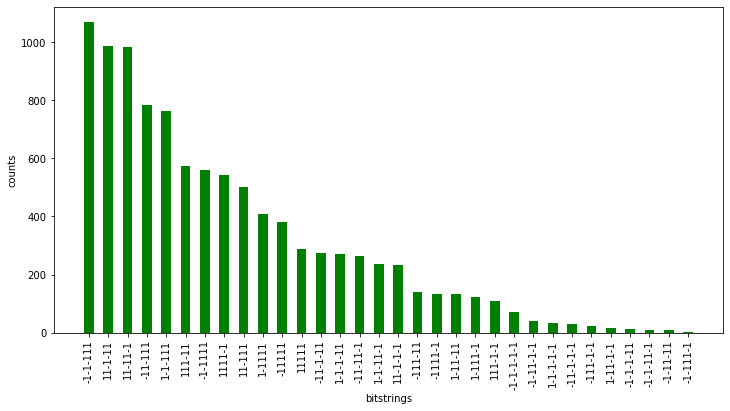

In [81]:
#lo stato cercato è sempre della top 3 ma non è detto sia sempre il primo... sentire D e S

basis="Z"

ix_f1_min = np.argmin(f1)
f1_min = f1[ix_f1_min] #chiaramente è difficile aspettarsi che sia il minimo esatto, perché è un valore di aspettazione
optimal_params = params[ix_f1_min]
print("Optimal parameters, according to the grid search, are: {optimal_params}")
extimated_f1, pretty_counts = QAOA(*optimal_params, shots=10000, basis=basis) #prendo un numero molto grande di shots per stabilizzare la distribuzione (legge grandi numeri)
plot_distribution(pretty_counts)
sol = pd.DataFrame(dict(sorted(pretty_counts.items(), key=lambda item: item[1], reverse=True)),index=[0]).T.reset_index()
sol.columns=["configuration","occurrencies"]
sol["frequency"]=round(sol["occurrencies"]/sol["occurrencies"].sum()*100,0)#.head(3)
sol["energy"]=sol["configuration"].apply(lambda x: evaluate_cost(str2list(x),basis=basis))
sol=sol[["configuration","energy","occurrencies","frequency"]]
sol.head(10)

### Bayesian Optimization to find the minimum of the f1 of a graph


In [137]:
#Allows to change max_iter (see cell below) as well as gtol. It can be straightforwardly extended to other parameters
class MyGaussianProcessRegressor(GaussianProcessRegressor):
    def __init__(self, *args, max_iter=2e05, gtol=1e-06, **kwargs):
        super().__init__(*args, **kwargs)
        self._max_iter = max_iter
        self._gtol = gtol

    def _constrained_optimization(self, obj_func, initial_theta, bounds):
        if self.optimizer == "fmin_l_bfgs_b":
            opt_res = minimize(obj_func, initial_theta, method="L-BFGS-B", jac=True, bounds=bounds, options={'maxiter':self._max_iter, 'gtol': self._gtol})
            _check_optimize_result("lbfgs", opt_res)
            theta_opt, func_min = opt_res.x, opt_res.fun
        elif callable(self.optimizer):
            theta_opt, func_min = self.optimizer(obj_func, initial_theta, bounds=bounds)
        else:
            raise ValueError("Unknown optimizer %s." % self.optimizer)
        return theta_opt, func_min
    
def rescaler(x, min_old=0, max_old=np.pi, min_new=0, max_new=1):
    
    x_sc = min_new + (max_new - min_new)/(max_old - min_old)*(x - min_old)
    
    return x_sc

In [132]:
acq_function = 'EI'
N_train = 10
N_test = 100
iterations = 100
gamma_extremes = [0, np.pi]; beta_extremes = [0, np.pi]
X_train = []; y_train = []

#seed
my_seed = 42
np.random.seed(my_seed)

for i in range(N_train):
    X = [np.random.uniform(*gamma_extremes), np.random.uniform(*beta_extremes)]
    X_train.append(X)
    Y, _ = QAOA(*X)
    y_train.append(Y)

X= np.linspace(0, np.max([gamma_extremes, beta_extremes]), N_test)
X_test = list(product(X, X))

X_train = rescaler(np.array(X_train)).tolist()
X_test = rescaler(np.array(X_test)).tolist()

#create gaussian process and fit training data
kernel = CK(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = MyGaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, alpha = 1e-2, normalize_y = True, max_iter = 50000)
gp.fit(X_train, y_train)

#At each iteration we calculate the best point where to sample from
sample_points = []   #We save every point that was chosen to sample from

for i in range(iterations):
        
        # Test GP
        new_mean, new_sigma = gp.predict(X_test, return_std=True)
        
        #New_mean and new_sigma both are (N_test**2, ) arrays not reshaped yet
        mean_max = np.max(new_mean)
        mean_min = np.min(new_mean)
        
        #Now calculate acquisitition fn as the cumulative for every point centered around the maximum
        cdf = norm.cdf(x = new_mean, loc =  mean_max, scale = new_sigma)
        pdf = norm.pdf(x = new_mean, loc =  mean_min, scale = new_sigma)
    
        #The qdf is instead the probability of being lower then the lowest value of the mean (where we wanto to pick the next_value)
        qdf = 1-norm.cdf(x = new_mean, loc =  mean_min, scale = new_sigma)
    
        if acq_function == 'PI':
            #Next values is calculated as so just because argmax returns a number betwenn 1 and n_test instead of inside the interval
            value = np.argmax(qdf)
            next_point = X_test[value]
            
        if acq_function == 'EI':
            alpha_function = (new_mean - mean_min - 0.001)*qdf + new_sigma*pdf
            #argmax is a number between 0 and N_test**-1 telling us where is the next point to sample
            argmax = np.argmax(np.round(alpha_function, 3))
            next_point_normalized = X_test[argmax]
        
        next_point = rescaler(np.array(next_point_normalized), min_old=0, max_old=1, min_new=0, max_new=np.pi)
        X_train.append(next_point_normalized)
        y_next_point,_ = QAOA(*next_point)
        y_train.append(y_next_point)
        print(i, next_point, y_next_point)

        gp.fit(X_train, y_train)
        sample_points.append(next_point)
        
        #if i>3 and np.sum((np.abs(sample_points[-1] - sample_points[-2] - sample_points[-3]))<1e-3) ==2:
        #    print('Converged')
        #    break
            
print('reached limit')

0 [0.        2.0943951] 0.03299999999999992
1 [0.92026451 2.28479466] -0.725
2 [1.58666296 1.68186273] -0.15799999999999995
3 [0.60293192 2.82426006] -1.1680000000000001
4 [2.53866073 2.69732703] -1.2550000000000001
5 [3.14159265 2.47519421] 0.075
6 [2.18959488 3.14159265] 0.025999999999999912
7 [2.47519421 2.41172769] -0.7850000000000001
8 [2.9511931  3.14159265] -0.011999999999999969
9 [0.47599889 2.47519421] -1.0260000000000002
10 [0.63466518 2.66559377] -1.236
11 [0.50773215 2.66559377] -1.334
12 [0.50773215 2.66559377] -1.3430000000000002
13 [0.50773215 2.69732703] -1.395
14 [0.50773215 2.66559377] -1.3479999999999999
15 [0.50773215 2.69732703] -1.3900000000000001
16 [0.50773215 2.69732703] -1.323
17 [0.50773215 2.69732703] -1.3610000000000002
18 [0.50773215 2.69732703] -1.4010000000000002
19 [0.50773215 2.72906028] -1.413
20 [0.50773215 2.72906028] -1.4500000000000002


<ipython-input-7-781a3129b33c>:11: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


21 [0.50773215 2.69732703] -1.405
22 [1.61839622 0.        ] -0.007000000000000034


<ipython-input-7-781a3129b33c>:11: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


23 [0.47599889 2.72906028] -1.3450000000000002
24 [0.50773215 2.69732703] -1.391
25 [0.50773215 2.69732703] -1.409
26 [0.50773215 2.69732703] -1.373
27 [0.50773215 2.69732703] -1.457
28 [0.47599889 2.72906028] -1.4290000000000003
29 [0.47599889 2.72906028] -1.4450000000000003
30 [0.50773215 2.72906028] -1.3540000000000003
31 [0.50773215 2.72906028] -1.3470000000000004
32 [0.50773215 2.72906028] -1.4180000000000001
33 [0.50773215 2.72906028] -1.4160000000000001
34 [0.50773215 2.72906028] -1.4400000000000002
35 [0.50773215 2.72906028] -1.3710000000000004
36 [0.47599889 2.72906028] -1.463


<ipython-input-7-781a3129b33c>:11: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


37 [0.47599889 2.76079354] -1.358
38 [0.47599889 2.72906028] -1.4760000000000004
39 [0.47599889 2.72906028] -1.4340000000000002
40 [0.47599889 2.72906028] -1.4120000000000001
41 [0.47599889 2.72906028] -1.4340000000000002
42 [0.47599889 2.76079354] -1.4120000000000001
43 [0.47599889 2.76079354] -1.4260000000000002
44 [3.14159265 1.58666296] 0.13799999999999998
45 [0.47599889 2.76079354] -1.4110000000000003
46 [0.47599889 2.76079354] -1.3980000000000004
47 [0.47599889 2.76079354] -1.377
48 [0.47599889 2.72906028] -1.409
49 [0.44426563 2.72906028] -1.3930000000000002
50 [0.47599889 2.72906028] -1.4150000000000003
51 [0.47599889 2.72906028] -1.407
52 [0.44426563 2.72906028] -1.457


<ipython-input-7-781a3129b33c>:11: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


53 [0.44426563 2.72906028] -1.4580000000000002
54 [3.14159265 0.        ] 0.23099999999999996
55 [0.44426563 2.76079354] -1.473
56 [0.44426563 2.72906028] -1.4390000000000003
57 [0.44426563 2.72906028] -1.4110000000000005
58 [0.44426563 2.72906028] -1.3900000000000001
59 [0.44426563 2.72906028] -1.3970000000000002
60 [0.44426563 2.72906028] -1.4690000000000003
61 [0.44426563 2.72906028] -1.4040000000000004
62 [0.44426563 2.72906028] -1.3230000000000002
63 [0.44426563 2.72906028] -1.3770000000000004
64 [0.44426563 2.72906028] -1.3770000000000002
65 [0.47599889 2.76079354] -1.4420000000000002
66 [0.44426563 2.72906028] -1.453
67 [0.44426563 2.72906028] -1.4420000000000004
68 [0. 0.] 0.03799999999999991
69 [0.44426563 2.72906028] -1.477
70 [0.44426563 2.72906028] -1.3890000000000005
71 [0.44426563 2.72906028] -1.4130000000000003
72 [0.44426563 2.72906028] -1.3900000000000001
73 [0.44426563 2.72906028] -1.4270000000000003
74 [0.44426563 2.72906028] -1.4500000000000004
75 [0.44426563 2.7290

In [355]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from itertools import product
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler

#decide acquisition function
acq_function = 'EI'
N_train = 1
N_test = 50 #Number of test elements
iterations = 100
gamma_extremes = [0, np.pi]  #extremes where to search for the values of gamma and beta
beta_extremes = [0, np.pi]

#create dataset: We start with N random points
X_train = []   #data
y_train = []   #label
np.random.seed(9320)
for i in range(N_train):
    X = [np.random.uniform(gamma_extremes[0],gamma_extremes[1]), np.random.uniform(beta_extremes[0],beta_extremes[1])]
    #X = [.5, 1.5]
    X_train.append(X)
    Y, _ = QAOA(*X)
    y_train.append(Y)

X= np.linspace(0, np.max([gamma_extremes, beta_extremes]), N_test)
X_test = list(product(X, X))

X_train = my_rescaler(np.array(X_train)).tolist()
X_test = my_rescaler(np.array(X_test)).tolist()

#create gaussian process and fit training data
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = MyGaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, alpha = 1e-2, normalize_y = True, max_iter = 50000)
gp.fit(X_train, y_train)

#At each iteration we calculate the best point where to sample from
sample_points = []   #We save every point that was chosen to sample from
convergence_check = 0
for i in range(iterations):
        # Test GP
        new_mean, new_sigma = gp.predict(X_test, return_std=True)
        
        #New_mean and new_sigma both are (N_test**2, ) arrays not reshaped yet
        mean_max = np.max(new_mean)
        mean_min = np.min(new_mean)
        
        #Now calculate acquisitition fn as the cumulative for every point centered around the maximum
        cdf = norm.cdf(x = new_mean, loc =  mean_max, scale = new_sigma)
        pdf = norm.pdf(x = new_mean, loc =  mean_min, scale = new_sigma)
    
        #The qdf is instead the probability of being lower then the lowest value of the mean (where we wanto to pick the next_value)
        qdf = 1-norm.cdf(x = new_mean, loc =  mean_min, scale = new_sigma)
    
        if acq_function == 'PI':
            #Next values is calculated as so just because argmax returns a number betwenn 1 and n_test instead of inside the interval
            value = np.argmax(qdf)
            next_point = X_test[value]
            
        if acq_function == 'EI':
            alpha_function = (new_mean - mean_min - 0.001)*qdf + new_sigma*pdf
            #argmax is a number between 0 and N_test**-1 telling us where is the next point to sample
            argmax = np.argmax(np.round(alpha_function, 3))
            next_point_normalized = X_test[argmax]
        
        next_point = my_rescaler(np.array(next_point_normalized), min_old=0, max_old=1, min_new=0, max_new=np.pi)
        X_train.append(next_point_normalized)
        y_next_point,_ = QAOA(*next_point)
        y_train.append(y_next_point)
        print(i, next_point, y_next_point, convergence_check)

        gp.fit(X_train, y_train)
        sample_points.append(next_point)
        
        if i>3 and np.sum((np.abs(sample_points[-1] - sample_points[-2] - sample_points[-3]))<1e-3) ==2:
            print('Converged')
            break
print('reached limit')

C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


0 [0. 0.] -0.05299999999999999 0
1 [0.         0.06411414] -0.0010000000000000842 0
2 [0. 0.] -0.10600000000000008 0
3 [0.         1.41051099] 1.3877787807814457e-17 0
4 [0.         1.98753821] 0.034999999999999955 0
5 [0.51291309 1.53873926] 0.10300000000000004 0
6 [0.        2.6927937] -0.05400000000000002 0
7 [0.57702722 2.6927937 ] -1.2869999999999997 0
8 [0.76936963 2.75690784] -1.062 0
9 [0.64114136 2.56456543] -1.1540000000000001 0
10 [0.57702722 2.75690784] -1.399 0
11 [0.51291309 2.94925025] -1.0710000000000002 0
12 [0.57702722 2.6927937 ] -1.3709999999999998 0
13 [0.57702722 2.6927937 ] -1.296 0
14 [0.57702722 2.6927937 ] -1.3359999999999996 0
15 [0.57702722 2.6927937 ] -1.3119999999999996 0
16 [0.57702722 2.6927937 ] -1.3310000000000002 0
17 [0.57702722 2.75690784] -1.2500000000000002 0
18 [2.43633716 1.28228272] 0.74 0
19 [2.56456543 3.14159265] -0.013999999999999999 0
20 [0.51291309 2.6927937 ] -1.3950000000000002 0
21 [3.07747852 0.        ] -0.05299999999999992 0
22 [0.5

<ipython-input-137-1c42e4b07629>:11: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


55 [0.51291309 2.6927937 ] -1.3590000000000002 0
56 [0.51291309 2.6927937 ] -1.3980000000000001 0
57 [0.51291309 2.6927937 ] -1.3150000000000002 0
58 [0.51291309 2.6927937 ] -1.4200000000000002 0
59 [0.51291309 2.6927937 ] -1.3910000000000002 0
60 [0.51291309 2.6927937 ] -1.4140000000000004 0
61 [0.51291309 2.6927937 ] -1.3760000000000001 0
62 [0.51291309 2.6927937 ] -1.4300000000000002 0
63 [0.51291309 2.6927937 ] -1.4090000000000003 0
64 [0.51291309 2.6927937 ] -1.4000000000000001 0
65 [0.51291309 2.6927937 ] -1.375 0
66 [0.51291309 2.6927937 ] -1.4030000000000005 0
67 [0.51291309 2.6927937 ] -1.4380000000000002 0
68 [0.51291309 2.6927937 ] -1.397 0
69 [0.51291309 2.6927937 ] -1.3900000000000001 0
70 [0.51291309 2.6927937 ] -1.3070000000000002 0
71 [0.51291309 2.6927937 ] -1.435 0
72 [0.51291309 2.6927937 ] -1.3800000000000003 0
73 [0.51291309 2.6927937 ] -1.356 0
74 [0.51291309 2.6927937 ] -1.432 0
75 [0.51291309 2.6927937 ] -1.385 0
76 [0.51291309 2.6927937 ] -1.4109999999999998 0


Optimal f1: -1.3


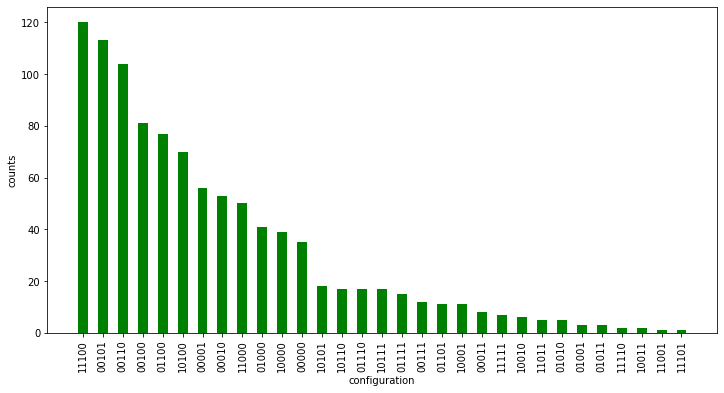

In [359]:
optimal_points = sample_points[-1]
optimal_f1, counts = QAOA(*optimal_points,shots=1000, basis="S")
print(f"Optimal f1: {f1_trial}")
plot_distribution(counts)

100%|████████████████████████████████████████████████████████████████████████████| 40000/40000 [08:27<00:00, 78.75it/s]


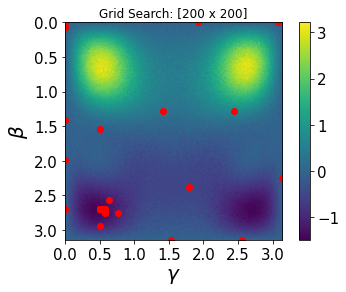

In [383]:
points = grid_search(200, shots=1000)
sample_points = np.array(sample_points)
plt.scatter(sample_points[:,0], sample_points[:,1], c = 'r')
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()